We will reproduce the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) here.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print(hddm.__version__)

0.8.0


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.7/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


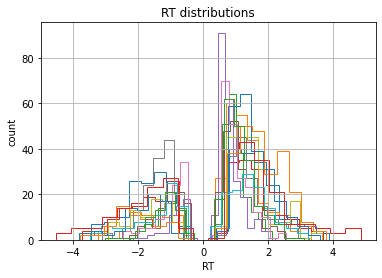

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [7]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [8]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [9]:
# define a function to run model in parallel
def run_m(id):
    print('running model (depends on stim) %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(5000, burn=1000,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [10]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_stim_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
676.020s elapsed

running model (depends on stim) 0
 [-----------------99%----------------- ] 4964 of 5000 complete in 672.4 sec
running model (depends on stim) 1
 [-----------------98%----------------- ] 4939 of 5000 complete in 671.6 sec
running model (depends on stim) 2
 [-----------------100%-----------------] 5000 of 5000 complete in 672.2 sec
running model (depends on stim) 3
 [-----------------98%----------------- ] 4939 of 5000 complete in 671.4 sec



Running 4 chains used: 691.043377 seconds.


In [11]:
m_stim_all = kabuki.utils.concat_models(m_stim_list) 

Text(0.5, 1.0, 'Posterior of drift-rate group means')

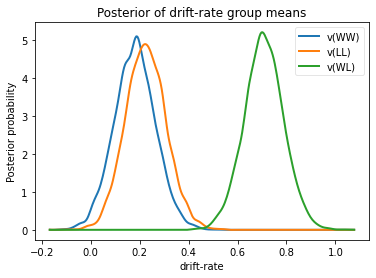

In [12]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [13]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.35325
P(LL > WL) =  0.0001875


## Convert HDDM objects to ArviZ?

Let's try to compare `m_stim_list` and `m_reg_list` in the above models.

To convert a `HDDM` object to an `ArviZ` InferenceData and use all the functionality of `ArviZ`, we need to convert the following parts:

* observed_data: the data on which the posterior is conditional. Each variable should have a counter part.

* Posterior: Samples from the posterior distribution $p(\theta | y)$, which is the trace from pymc.

* sample_stats: Information and diagnostics for each `posterior` sample, provided by the inference backend. 

* log_likelihood: pointwise log likelihood data. Sample shoudl match with `posteior` ones and its variables should match `observed_data` variables. 

* posterior_predictive: the posterior predictive distribution evaluated at the `observed_data`. Samples should match with `posterior` ones and its variables should match `observed_data` variables. The `observed_data` counterpart variable may have a different name.

* prior: Samples from the prior distriubtion $p(\theta)$. Samples need not to match `posterior`. still follow the convertion on `chain` and `draw` as first dimensions.

* prior_predictive. Samples from the `prior` predictive distribution. Samples should match `prior` samples and each variable should have a counterpart in `posterior_predictive/observed_data`.

In [14]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

In [15]:
print("DIC of m_depends_on is %.5f" % m_stim_all.dic)

DIC of m_depends_on is 10786.49509


### `observed_data`

In this example data, we have 14 participants, each with three different conditions, each condition has different trial numbers.

In [16]:
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,-1.14,0.0,-0.213236,1,HC


In [17]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

In [18]:
data_tmp = data.copy()
data_tmp['trial'] = data_tmp.groupby(['subj_idx', 'stim']).cumcount()

data_tmp.head()


,subj_idx,stim,rt,response,theta,dbs,conf,trial
0,0,LL,1.21,1.0,0.656275,1,HC,0
1,0,WL,1.63,1.0,-0.327889,1,LC,0
2,0,WW,1.03,1.0,-0.480285,1,HC,0
3,0,WL,2.77,1.0,1.927427,1,LC,1
4,0,WW,-1.14,0.0,-0.213236,1,HC,1


In [19]:
data_tmp = data_tmp.set_index(["subj_idx", "stim", 'trial'])
xdata_observed = xr.Dataset.from_dataframe(data_tmp)
xdata_observed

<xarray.Dataset>
Dimensions:   (stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    rt        (subj_idx, stim, trial) float64 1.21 2.0 1.72 1.72 ... nan nan nan
    response  (subj_idx, stim, trial) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    theta     (subj_idx, stim, trial) float64 0.6563 -0.2745 0.6492 ... nan nan
    dbs       (subj_idx, stim, trial) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    conf      (subj_idx, stim, trial) object 'HC' 'HC' 'HC' 'HC' ... nan nan nan

### `posterior`
The `posterior` is from the traces

In [20]:
df_stim_traces = []
for i in range(4):
    df = m_stim_list[i]
    df_trace = df.get_traces()
    df_trace['chain'] = i
    df_trace['draw'] = np.arange(len(df_trace), dtype=int)
    print('chain', i, df_trace.shape)
    df_stim_traces.append(df_trace)
df_stim_traces = pd.concat(df_stim_traces)
df_stim_traces = df_stim_traces.set_index(["chain", "draw"])

chain 0 (4000, 80)
chain 1 (4000, 80)
chain 2 (4000, 80)
chain 3 (4000, 80)


In [21]:
xposterior_stim = xr.Dataset.from_dataframe(df_stim_traces)
xposterior_stim

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 4000)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
Data variables: (12/78)
    a              (chain, draw) float64 1.952 1.784 1.86 ... 2.17 2.15 2.013
    a_std          (chain, draw) float64 0.3642 0.3154 0.3288 ... 0.4388 0.407
    a_subj.0       (chain, draw) float64 2.069 2.065 2.182 ... 2.18 2.137 2.284
    a_subj.1       (chain, draw) float64 2.12 2.166 2.131 ... 2.181 2.154 2.157
    a_subj.2       (chain, draw) float64 1.626 1.601 1.527 ... 1.511 1.502 1.504
    a_subj.3       (chain, draw) float64 2.174 2.129 2.092 ... 2.169 2.218 2.064
    ...             ...
    t_subj.8       (chain, draw) float64 0.5623 0.519 0.5182 ... 0.4937 0.5561
    t_subj.9       (chain, draw) float64 0.3864 0.3737 0.36 ... 0.3633 0.3742
    t_subj.10      (chain, draw) float64 0.6598 0.6522 0.6537 ... 0.6741 0.6681
    t_subj.11      (chain, draw) float64 0.6067 0.6124 0.6132 ... 0.6271 0.6267
    t_subj.12      (chain, draw) float64 0.3786 0.3631 0.4023 ... 0.4099 0.3904
    t_subj.13      (chain, draw) float64 0.5935 0.538 0.5442 ... 0.4689 0.4959

### `posterior_predictive`


In [22]:
df_stim_post_preds = []
for i in range(4):
    df = m_stim_list[i]
    df_post_pred = hddm.utils.post_pred_gen(df, samples = 4000)
    df_post_pred.reset_index(inplace=True)
    df_post_pred['chain'] = i
    df_post_pred.rename(columns={'sample':'draw',
                                 'level_2':'trial'}, inplace=True)
    print('chain', i, df_post_pred.shape)
    df_stim_post_preds.append(df_post_pred)
df_stim_post_preds = pd.concat(df_stim_post_preds)

 [------------------107%------------------] 45 of 42 complete in 1949.6 secchain 0 (15952000, 6)
 [------------------107%------------------] 45 of 42 complete in 1941.8 secchain 1 (15952000, 6)
 [------------------107%------------------] 45 of 42 complete in 1915.4 secchain 2 (15952000, 6)
 [------------------107%------------------] 45 of 42 complete in 1924.7 secchain 3 (15952000, 6)


In [ ]:
# split the node column into stim and subj_idx
df_stim_post_preds[['stim', 'subj_idx']] = df_stim_post_preds['node'].str.split(pat='\.', expand=True)

# extract the stim string between "(" and ")"

df_stim_post_preds['stim'] = df_stim_post_preds['stim'].str.extract('.*\((.*)\).*')
df_stim_post_preds.groupby(['chain', 'draw','subj_idx', 'stim']).size()

In [115]:
df_stim_post_preds = df_stim_post_preds.set_index(["chain", "draw"])
xdata_post_pred = xr.Dataset.from_dataframe(df_stim_post_preds)

In [ ]:
tmp_pps.groupby(['node','level_2']).size()

In [ ]:
InfData_stim = az.InferenceData(posterior=xposterior_stim)

InfData_stim

In [30]:
type(m_stim_list)

list

In [52]:
m_stim_list[0].nodes_db.node[:]

a                        a
a_std                a_std
a_rate              a_rate
a_shape            a_shape
a_subj.0          a_subj.0
                  ...     
wfpt(WW).9      wfpt(WW).9
wfpt(WW).10    wfpt(WW).10
wfpt(WW).11    wfpt(WW).11
wfpt(WW).12    wfpt(WW).12
wfpt(WW).13    wfpt(WW).13
Name: node, Length: 125, dtype: object

In [32]:
m_reg_list[0].nodes_db.node[:]

a                  a
a_std          a_std
a_rate        a_rate
a_shape      a_shape
a_subj.0    a_subj.0
              ...   
wfpt.9        wfpt.9
wfpt.10      wfpt.10
wfpt.11      wfpt.11
wfpt.12      wfpt.12
wfpt.13      wfpt.13
Name: node, Length: 83, dtype: object

In [54]:
tmp = m_reg_list[0].mcmc

In [34]:
m_stim_traces = m_stim_list[0].get_traces()
m_stim_traces.head()

,a,a_std,a_subj.0,a_subj.1,a_subj.2,a_subj.3,a_subj.4,a_subj.5,a_subj.6,a_subj.7,...,t_subj.4,t_subj.5,t_subj.6,t_subj.7,t_subj.8,t_subj.9,t_subj.10,t_subj.11,t_subj.12,t_subj.13
0,1.990941,0.265858,2.254434,2.092083,1.628092,2.255437,1.434063,1.759185,1.489983,1.804662,...,0.354700,0.355529,0.429972,0.595347,0.563349,0.334341,0.654380,0.583046,0.397313,0.486013
1,2.019152,0.261494,2.264979,2.245491,1.623557,2.244631,1.577441,1.848503,1.572699,1.807290,...,0.345969,0.354972,0.437612,0.594731,0.526854,0.333178,0.621675,0.641408,0.401835,0.490364
2,2.083371,0.434556,2.281305,2.247312,1.581289,2.223467,1.489564,1.818833,1.575797,1.786472,...,0.343126,0.330012,0.426574,0.603866,0.545837,0.395591,0.640162,0.627515,0.403595,0.496660
3,2.042693,0.272911,2.234022,2.235896,1.554833,2.172882,1.487867,1.753617,1.592126,1.851019,...,0.351149,0.354227,0.424887,0.597953,0.576080,0.396204,0.622139,0.614174,0.398535,0.494063
4,2.090359,0.424472,2.218345,2.119880,1.701151,2.158681,1.483172,1.728415,1.607493,1.785123,...,0.343433,0.361366,0.412649,0.587852,0.593101,0.384981,0.655373,0.583218,0.393810,0.502532


In [35]:
m_reg_traces = m_reg_list[0].get_traces()
m_reg_traces.head()

,a,a_std,a_subj.0,a_subj.1,a_subj.2,a_subj.3,a_subj.4,a_subj.5,a_subj.6,a_subj.7,...,v_Intercept_subj.6,v_Intercept_subj.7,v_Intercept_subj.8,v_Intercept_subj.9,v_Intercept_subj.10,v_Intercept_subj.11,v_Intercept_subj.12,v_Intercept_subj.13,"v_C(stim, Treatment('WL'))[T.LL]","v_C(stim, Treatment('WL'))[T.WW]"
0,2.083778,0.377117,2.247292,2.165455,1.577938,2.133328,1.471341,1.828306,1.602688,1.837582,...,0.645374,0.310906,0.784197,0.438812,0.704921,0.792337,0.843608,0.366346,-0.443274,-0.462868
1,2.055615,0.349157,2.248323,2.158002,1.532565,2.115395,1.535752,1.825113,1.528996,1.898332,...,0.574115,0.263781,0.699234,0.405404,0.722521,0.890695,0.867119,0.440928,-0.427847,-0.451124
2,1.997488,0.353393,2.319158,2.087621,1.554925,2.144755,1.546396,1.786230,1.585078,1.860820,...,0.653588,0.278778,0.706333,0.417329,0.648329,0.830072,0.804554,0.495751,-0.485130,-0.426229
3,2.042896,0.256730,2.199479,2.250882,1.588452,2.116246,1.420487,1.713460,1.575097,1.933254,...,0.684056,0.307770,0.734980,0.469354,0.665990,0.937427,0.908318,0.369467,-0.410589,-0.501259
4,2.039311,0.328222,2.175882,2.008951,1.618981,2.121216,1.448446,1.849355,1.586195,1.871127,...,0.739080,0.234334,0.637887,0.406490,0.734374,0.810252,0.803469,0.411261,-0.410348,-0.501757


In [36]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

`az.plot_trace()` needs `chain`

To finished that, we need first understand the data structure, e.g., `c (chain, draw, c1, c2)`.

`az.hdi()` needs `chain`, `draw`

`az.loo()` and `az.waic()` needs `log likelihood`

### Tried to draw from prior (failed)

In [70]:
tmp = m_stim_list[0]
draw_from_prior(tmp, update=False)
# tmp.draw_from_prior(update=False)

AttributeError: Deterministic a_rate's value cannot be set.

In [50]:
df_stim_priors = []
for i in range(4):
    df = m_stim_list[i]
    df_prior = df.draw_from_prior()
    df_prior['chain'] = i
    df_prior['draw'] = np.arange(len(df_prior), dtype=int)
    print('chain', i, df_prior.shape)
    df_priors.append(df_trace)
df_stim_priors = pd.concat(df_stim_priors)
df_stim_priors = df_stim_priors.set_index(["chain", "draw"])

AttributeError: Deterministic a_rate's value cannot be set.

### try to get the posterior_predictive

In `post_pred_gen`, `samples` arugment define how many samples to generate for each node.

In the current case, our model has 4000 samples

In [96]:
tmp = m_stim_list[0]
tmp_ppc =hddm.utils.post_pred_gen(tmp)

 [------------------107%------------------] 45 of 42 complete in 242.3 sec

In [100]:
tmp_ppc.index.levels

FrozenList([['wfpt(LL).0', 'wfpt(LL).1', 'wfpt(LL).2', 'wfpt(LL).3', 'wfpt(LL).4', 'wfpt(LL).5', 'wfpt(LL).6', 'wfpt(LL).7', 'wfpt(LL).8', 'wfpt(LL).9', 'wfpt(LL).10', 'wfpt(LL).11', 'wfpt(LL).12', 'wfpt(LL).13', 'wfpt(WL).0', 'wfpt(WL).1', 'wfpt(WL).2', 'wfpt(WL).3', 'wfpt(WL).4', 'wfpt(WL).5', 'wfpt(WL).6', 'wfpt(WL).7', 'wfpt(WL).8', 'wfpt(WL).9', 'wfpt(WL).10', 'wfpt(WL).11', 'wfpt(WL).12', 'wfpt(WL).13', 'wfpt(WW).0', 'wfpt(WW).1', 'wfpt(WW).2', 'wfpt(WW).3', 'wfpt(WW).4', 'wfpt(WW).5', 'wfpt(WW).6', 'wfpt(WW).7', 'wfpt(WW).8', 'wfpt(WW).9', 'wfpt(WW).10', 'wfpt(WW).11', 'wfpt(WW).12', 'wfpt(WW).13'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,

In [111]:
tmp_ppc.head(20)

,level_0,index,node,sample,level_2,rt,response
0,0,0,wfpt(LL).0,0,0,0.975152,1.0
1,1,1,wfpt(LL).0,0,1,-1.652252,0.0
2,2,2,wfpt(LL).0,0,2,-0.818852,0.0
3,3,3,wfpt(LL).0,0,3,1.833352,1.0
4,4,4,wfpt(LL).0,0,4,0.833352,1.0
5,5,5,wfpt(LL).0,0,5,4.111252,1.0
6,6,6,wfpt(LL).0,0,6,1.812452,1.0
7,7,7,wfpt(LL).0,0,7,2.262152,1.0
8,8,8,wfpt(LL).0,0,8,-2.922652,0.0
9,9,9,wfpt(LL).0,0,9,0.941752,1.0


subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

In [112]:
tmp_ppc2 = tmp_ppc
# tmp_ppc2.reset_index(inplace=True)
tmp_ppc2.rename(columns={'sample':'draw'}, inplace=True)
tmp_ppc2.head()

,level_0,index,node,draw,level_2,rt,response
0,0,0,wfpt(LL).0,0,0,0.975152,1.0
1,1,1,wfpt(LL).0,0,1,-1.652252,0.0
2,2,2,wfpt(LL).0,0,2,-0.818852,0.0
3,3,3,wfpt(LL).0,0,3,1.833352,1.0
4,4,4,wfpt(LL).0,0,4,0.833352,1.0


In [106]:
tmp_ppc2.groupby(['node', 'sample']).size()

node        sample
wfpt(LL).0  0         73
            1         73
            2         73
            3         73
            4         73
                      ..
wfpt(WW).9  495       54
            496       54
            497       54
            498       54
            499       54
Length: 21000, dtype: int64

Comparing the post predictive check, we can found that `node` represents the combination of conditions and participants, `sample` is the number of samples, and `level_2` is corresponding to trial number

In [95]:
tmp_pps.groupby(['node','level_2']).size()

node        level_2
wfpt(LL).0  0          500
            1          500
            2          500
            3          500
            4          500
                      ... 
wfpt(WW).9  49         500
            50         500
            51         500
            52         500
            53         500
Length: 3988, dtype: int64

In [116]:
df_stim_post_preds.head()

node  level_2        rt  response
chain draw                                         
0     0     wfpt(LL).0        0  1.008503       1.0
      0     wfpt(LL).0        1  1.276703       1.0
      0     wfpt(LL).0        2  1.209203       1.0
      0     wfpt(LL).0        3  1.352003       1.0
      0     wfpt(LL).0        4 -1.584703       0.0

chain  draw  node        level_2
0      0     wfpt(LL).0  0          1
                         1          1
                         2          1
                         3          1
                         4          1
                                   ..
3      3999  wfpt(WW).9  49         1
                         50         1
                         51         1
                         52         1
                         53         1
Length: 63808000, dtype: int64

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [121]:
df_stim_traces.head()

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  \
chain draw                                                               
0     0     1.990941  0.265858  2.254434  2.092083  1.628092  2.255437   
      1     2.019152  0.261494  2.264979  2.245491  1.623557  2.244631   
      2     2.083371  0.434556  2.281305  2.247312  1.581289  2.223467   
      3     2.042693  0.272911  2.234022  2.235896  1.554833  2.172882   
      4     2.090359  0.424472  2.218345  2.119880  1.701151  2.158681   

            a_subj.4  a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  \
chain draw                                          ...                       
0     0     1.434063  1.759185  1.489983  1.804662  ...  0.354700  0.355529   
      1     1.577441  1.848503  1.572699  1.807290  ...  0.345969  0.354972   
      2     1.489564  1.818833  1.575797  1.786472  ...  0.343126  0.330012   
      3     1.487867  1.753617  1.592126  1.851019  ...  0.351149  0.354227   
      4     1.483172  1.728415  1.607493  1.785123  ...  0.343433  0.361366   

            t_subj.6  t_subj.7  t_subj.8  t_subj.9  t_subj.10  t_subj.11  \
chain draw                                                                 
0     0     0.429972  0.595347  0.563349  0.334341   0.654380   0.583046   
      1     0.437612  0.594731  0.526854  0.333178   0.621675   0.641408   
      2     0.426574  0.603866  0.545837  0.395591   0.640162   0.627515   
      3     0.424887  0.597953  0.576080  0.396204   0.622139   0.614174   
      4     0.412649  0.587852  0.593101  0.384981   0.655373   0.583218   

            t_subj.12  t_subj.13  
chain draw                        
0     0      0.397313   0.486013  
      1      0.401835   0.490364  
      2      0.403595   0.496660  
      3      0.398535   0.494063  
      4      0.393810   0.502532  

[5 rows x 78 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b914e6850>,
      dtype=object)

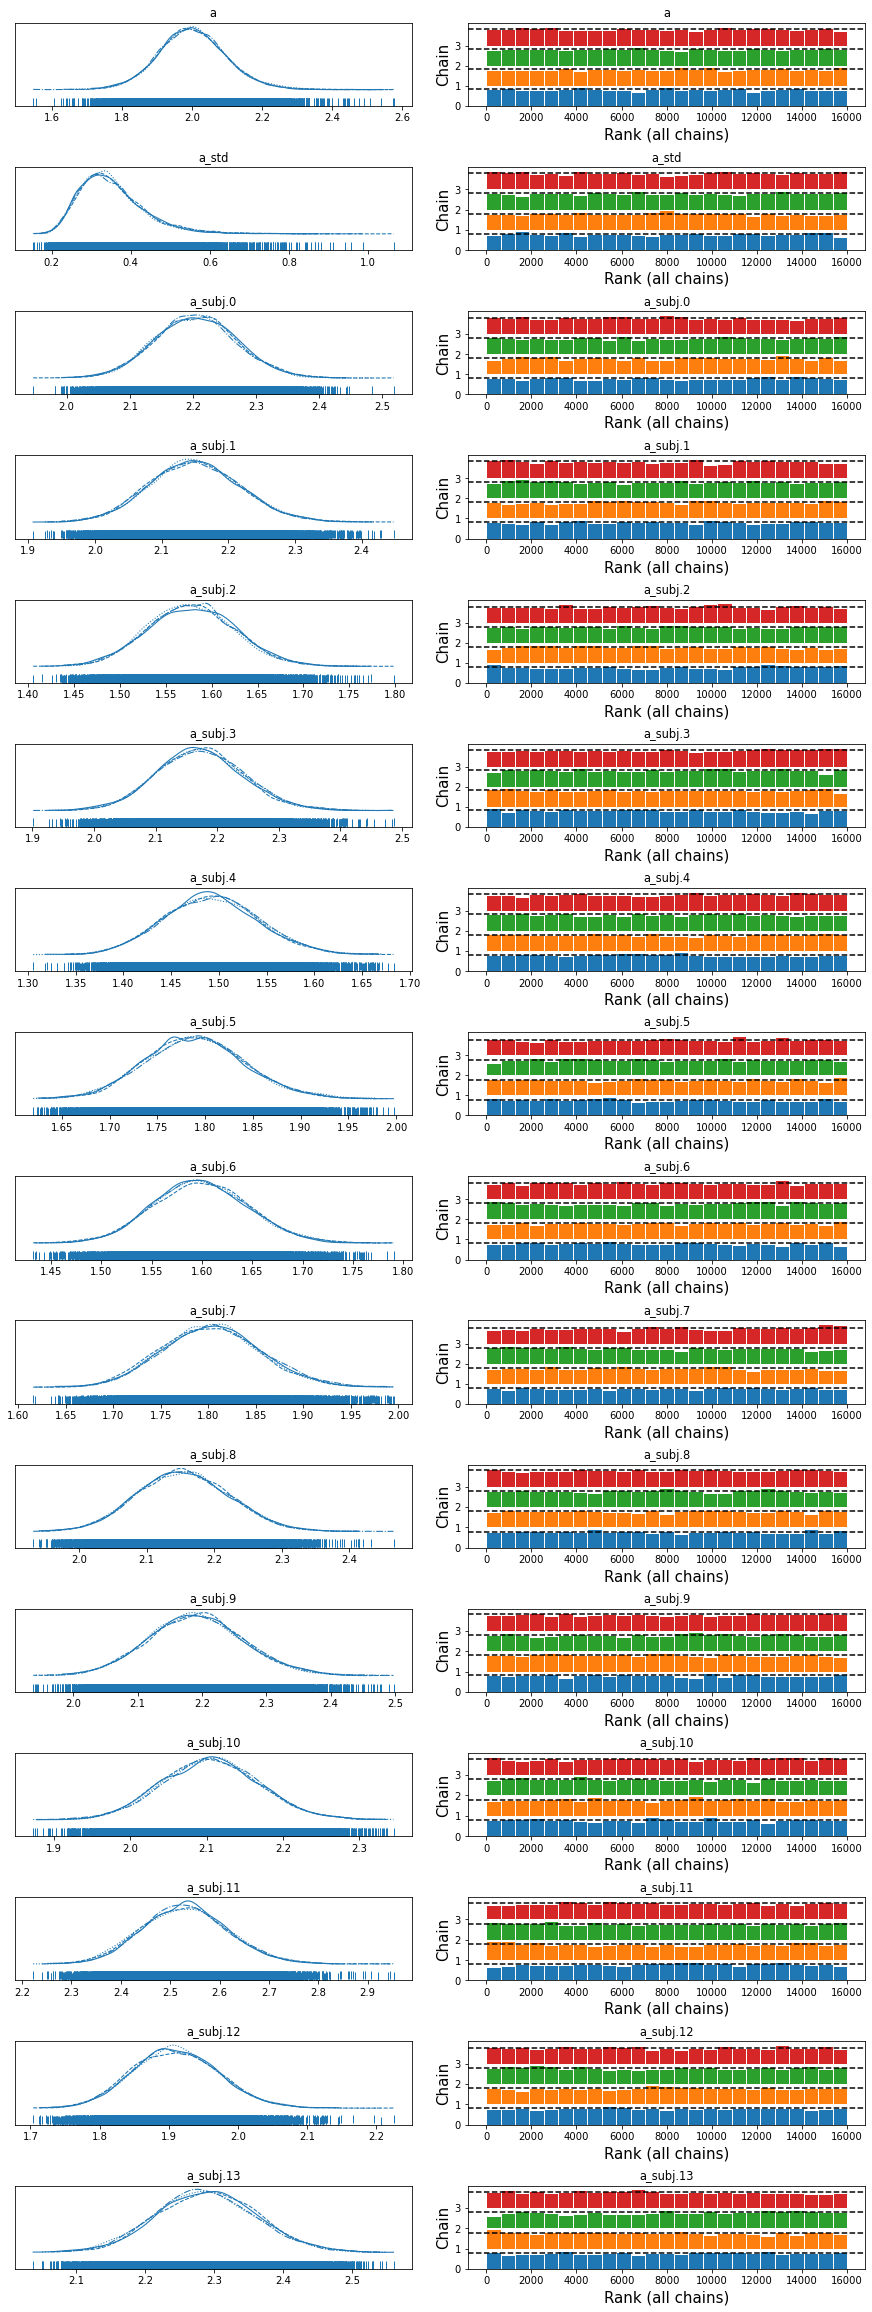

In [48]:
az.plot_trace(df_stim, var_names=("^a"), filter_vars='regex', rug=True, kind="rank_bars")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b90b3bf10>],
      dtype=object)

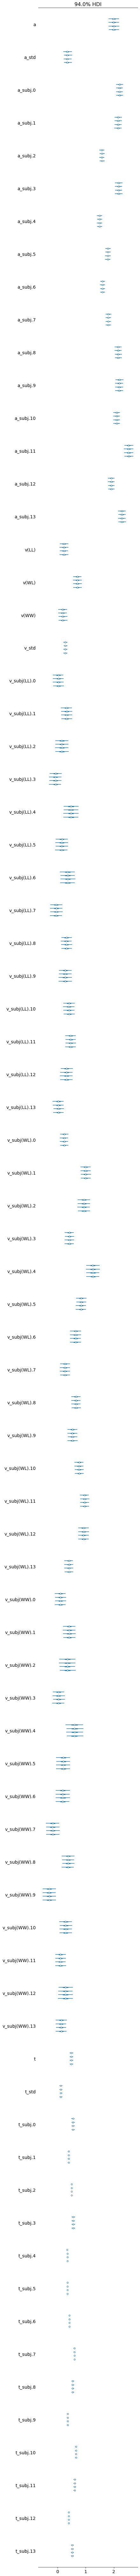

In [49]:
az.plot_forest(df_stim)

In [40]:
az.hdi(df_stim)

<xarray.Dataset>
Dimensions:        (hdi: 2)
Coordinates:
  * hdi            (hdi) <U6 'lower' 'higher'
Data variables: (12/78)
    a              (hdi) float64 1.818 2.187
    a_std          (hdi) float64 0.2147 0.5063
    a_subj.0       (hdi) float64 2.082 2.324
    a_subj.1       (hdi) float64 2.02 2.277
    a_subj.2       (hdi) float64 1.488 1.667
    a_subj.3       (hdi) float64 2.04 2.306
    ...             ...
    t_subj.8       (hdi) float64 0.4949 0.5907
    t_subj.9       (hdi) float64 0.325 0.398
    t_subj.10      (hdi) float64 0.6196 0.6894
    t_subj.11      (hdi) float64 0.5612 0.6512
    t_subj.12      (hdi) float64 0.3732 0.4234
    t_subj.13      (hdi) float64 0.4763 0.5758

In [47]:
az.plot_ppc(df_stim)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [46]:
az.loo(df_stim)

TypeError: log likelihood not found in inference data object

In [64]:
az.waic(df_reg)

TypeError: log likelihood not found in inference data object

In [41]:
datadict = {
    "a": np.random.randn(10),
    "b": np.random.randn(1, 10, 10),
    "c": np.random.randn(1, 10, 3, 4),
}

coords = {"c1": np.arange(3), "c2": np.arange(4), "b1": np.arange(10)}

dims = {"b":["b1"], "c":["c1", "c2"]}

dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)
dataset

Inference data with groups:
	> posterior